# Creating a dataset for patch-wise stroke presence prediction

Method: split whole brain into many patches
Rationale: Create dataset for patch wise stroke presence classification to determine which topological features are most useful for vascular imaging


In [25]:
import sys
path_bnd = '../'
sys.path.insert(1, path_bnd)
import analysis_tools.data_loader as dl
from gsprep.visual_tools.visual import display, idisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from imblearn.under_sampling import NearMiss
from analysis_tools.utils.masked_rolling_subimage_transformer import MaskedRollingSubImageTransformer

## Import data

In [3]:
data_dir = '/Users/julian/stroke_research/brain_and_donuts/full_datasets'
filename = 'withAngio_all_2016_2017.npz'
clinical_inputs, ct_inputs, ct_lesion_GT, mri_inputs, mri_lesion_GT, brain_masks, ids, params = \
dl.load_structured_data(data_dir, filename=filename)

# Reshape ct_inputs as it has 1 channel
ct_inputs = ct_inputs.reshape((*ct_inputs.shape[:-1]))

Loading a total of 113 subjects.
Sequences used: {'ct_sequences': ['wbetted_Angio'], 'ct_label_sequences': ['wcoreg_VOI'], 'mri_sequences': [], 'mri_label_sequences': []}
0 subjects had been excluded.


## Setting up data exploration set

In [4]:
# Data subset
n_images = 5
subsampling_rate = 2
X = (ct_inputs[:n_images] * brain_masks[:n_images])[range(n_images), ::subsampling_rate, ::subsampling_rate, ::subsampling_rate]
y = (ct_lesion_GT[:n_images] * brain_masks[:n_images])[range(n_images), ::subsampling_rate, ::subsampling_rate, ::subsampling_rate]
masks = brain_masks[range(n_images), ::subsampling_rate, ::subsampling_rate, ::subsampling_rate]

print(X.shape)
print(y.shape)
print(masks.shape)

(5, 40, 48, 40)
(5, 40, 48, 40)
(5, 40, 48, 40)


In [34]:
# Normalise data
# Capping (threshold to 0-500 as values outside this range seem non relevant to the vascular analysis)
vmin = 0
vmax = 500
X[X < vmin] = vmin
X[X > vmax] = vmax

In [35]:
idisplay(X[0], mask=y[0])

Output()

Create a function to split the provided data into patches

In [36]:
def brain_to_subimages(X, y, mask, width, batch_size = 10):
    if isinstance(width, int):
        width = [width, width, width]

    masked_subimages_lesion_presence = []
    masked_subimages = []
    for batch_offset in tqdm(range(0, X.shape[0], batch_size)):
        X_batch = X[batch_offset:batch_offset+batch_size]
        y_batch = y[batch_offset:batch_offset+batch_size]
        mask_batch = mask[batch_offset:batch_offset+batch_size]
        masked_subimage_transformer = MaskedRollingSubImageTransformer(mask=mask_batch, width_list=[width], padding='valid', stride=width)
        batch_masked_subimages = masked_subimage_transformer.fit_transform(X_batch)
        batch_masked_subimages_lesion_segmentation = masked_subimage_transformer.fit_transform(y_batch)
        width_idx = 0 # only one width is used for dataset creation (but transformer returns list of widths)
        batch_masked_subimages_lesion_presence = [np.any(batch_masked_subimages_lesion_segmentation[subj_idx][width_idx], axis=(-3, -2, -1))
                                                  for subj_idx in range(X_batch.shape[0])]
        masked_subimages.append(batch_masked_subimages)
        masked_subimages_lesion_presence.append(batch_masked_subimages_lesion_presence)

    return np.squeeze(np.concatenate(masked_subimages)), np.concatenate(masked_subimages_lesion_presence)

In [37]:
patch_X, patch_y = brain_to_subimages(X, y, masks, width=9)
print('X dimensions:', patch_X.shape, patch_X[0].shape)
print('y dimensions:', patch_y.shape, patch_y[0].shape)

  0%|          | 0/1 [00:00<?, ?it/s]/Users/julian/.conda/envs/BnDs/lib/python3.7/site-packages/pgtda/images/pipeline.py:495: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/Users/julian/.conda/envs/BnDs/lib/python3.7/site-packages/pgtda/images/pipeline.py:495: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/Users/julian/.conda/envs/BnDs/lib/python3.7/site-packages/pgtda/images/pipeline.py:495: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future t

X dimensions: (5,) (74, 9, 9, 9)
y dimensions: (5,) (74,)


In [38]:
# split subject wise
X_train, X_test, y_train, y_test = train_test_split(patch_X, patch_y, test_size=0.3, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3,) (2,) (3,) (2,)


In [39]:
X_train, y_train = np.concatenate(X_train), np.concatenate(y_train)
X_test, y_test = np.concatenate(X_test), np.concatenate(y_test)
X_test, X_train = X_test.reshape(X_test.shape[0], -1), X_train.reshape(X_train.shape[0], -1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(221, 729) (148, 729) (221,) (148,)


In [40]:
undersampler = NearMiss(version=3)
undersampled_X_train, undersampled_y_train = undersampler.fit_resample(X_train, y_train)

34
(68, 729) (68,)


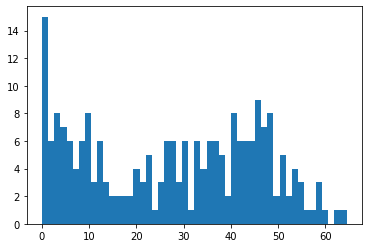

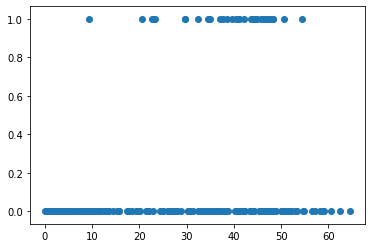

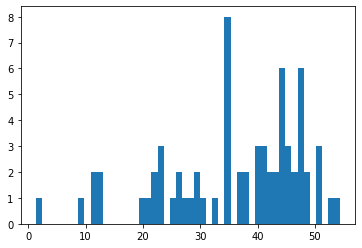

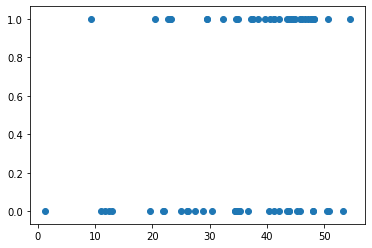

In [42]:
print(np.sum(y_train))
print(undersampled_X_train.shape, undersampled_y_train.shape)

plt.hist(np.mean(X_train, axis=-1), bins=50)
plt.show()
plt.scatter(np.mean(X_train, axis=-1), y_train)
plt.show()

plt.hist(np.mean(undersampled_X_train, axis=-1), bins=50)
plt.show()
plt.scatter(np.mean(undersampled_X_train, axis=-1), undersampled_y_train)
plt.show()
